In [1]:
import numpy as np
import pandas
import pm4py
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture
import scipy.stats as stats
import ot
import os
from tqdm import tqdm

In [2]:
event_log = pandas.read_pickle('artificial_start_end_2.pickle')
event_log

FileNotFoundError: [Errno 2] No such file or directory: 'artificial_start_end_2.pickle'

# Get real case durations

In [10]:
merged_event_log = pandas.merge(event_log,
                                event_log[['case:concept:name', 'time:timestamp_start']],
                                left_on=['case:concept:name'],
                                right_on=['case:concept:name'],
                                suffixes=('', '_case_start'))

start_end_start_case_event_log = merged_event_log.loc[merged_event_log.groupby(['case:concept:name', 'concept:name'])['time:timestamp_start_case_start'].idxmin()]

merged_event_log = pandas.merge(start_end_start_case_event_log,
                                start_end_start_case_event_log[['case:concept:name', 'time:timestamp_complete']],
                                left_on=['case:concept:name'],
                                right_on=['case:concept:name'],
                                suffixes=('', '_case_end'))

start_end_start_end_event_log = merged_event_log.loc[
    merged_event_log.groupby(['case:concept:name', 'concept:name'])['time:timestamp_complete_case_end'].idxmax()
]

In [11]:
case_duration_log = start_end_start_end_event_log.copy()
case_duration_log['case_duration'] = case_duration_log['time:timestamp_complete_case_end'] - case_duration_log['time:timestamp_start_case_start']
case_duration_log['case_duration_seconds'] = (case_duration_log['case_duration']).astype('timedelta64[s]').astype(int)

case_duration_log = case_duration_log.loc[case_duration_log.groupby('case:concept:name')['concept:name'].idxmin()]

case_duration_log = case_duration_log[['case:concept:name', 'time:timestamp_start_case_start', 'time:timestamp_complete_case_end',
                                       'case_duration', 'case_duration_seconds']]

case_duration_log

,case:concept:name,time:timestamp_start_case_start,time:timestamp_complete_case_end,case_duration,case_duration_seconds
1,0,2020-01-01 14:34:18.820288+00:00,2020-01-01 23:05:15.854003+00:00,0 days 08:30:57.033715,30657
10,1,2020-01-01 18:00:49.603934+00:00,2020-01-02 05:15:46.711023+00:00,0 days 11:14:57.107089,40497
19,10,2020-01-12 19:59:05.590033+00:00,2020-01-13 04:05:56.716266+00:00,0 days 08:06:51.126233,29211
28,100,2020-04-14 17:44:17.288791+00:00,2020-04-15 06:19:23.628814+00:00,0 days 12:35:06.340023,45306
37,1000,2022-07-11 20:26:25.689092+00:00,2022-07-12 05:09:29.696467+00:00,0 days 08:43:04.007375,31384
...,...,...,...,...,...
17030,995,2022-07-08 12:18:31.622463+00:00,2022-07-08 20:57:29.375155+00:00,0 days 08:38:57.752692,31137
17039,996,2022-07-09 00:20:25.132683+00:00,2022-07-09 19:02:42.462973+00:00,0 days 18:42:17.330290,67337
17048,997,2022-07-09 21:28:13.585886+00:00,2022-07-10 05:16:39.512122+00:00,0 days 07:48:25.926236,28105
17057,998,2022-07-10 07:48:58.547047+00:00,2022-07-10 20:58:08.635270+00:00,0 days 13:09:10.088223,47350


# Simulate case durations using model

In [12]:
from drbart_parser import *

### All

In [25]:
drbart = DRBART(parser_dir = '../../models/artificial/resource_concept_duration_seconds-day_resource-count_activity-count/')

In [26]:
event_log['duration_sampled'] = event_log.apply(lambda x : int(round(
                                                drbart.sample([x['org:resource'], x['concept:name'],
                                                              x['1'], x['Clark'], x['Jane'], x['Joe'], x['Karsten'],
                                                              x['DIAGNOSIS'], x['REPAIR']],
                                                              [x['seconds_in_day']])[1][0]
                                                                                ,0)), axis=1)

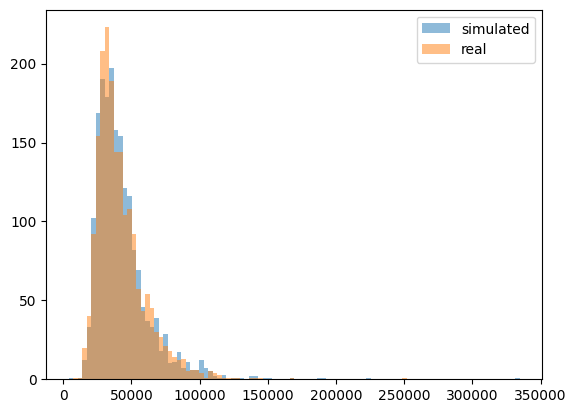

In [27]:
cased_duration_simulated = event_log.groupby('case:concept:name')['duration_sampled'].sum()
bins = 100
r = plt.hist(case_duration_log['case_duration_seconds'], bins, alpha=0.5, label='simulated')
plt.hist(cased_duration_simulated, r[1], alpha=0.5, label='real')
plt.legend(loc='upper right')
plt.show()

### Only resource

In [28]:
drbart = DRBART(parser_dir = '../../models/artificial/resource_duration_10000_100_100/')
event_log['duration_sampled'] = event_log.apply(lambda x : int(round(
                                                drbart.sample([x['org:resource']],
                                                              [])[1][0]
                                                                                ,0)), axis=1)

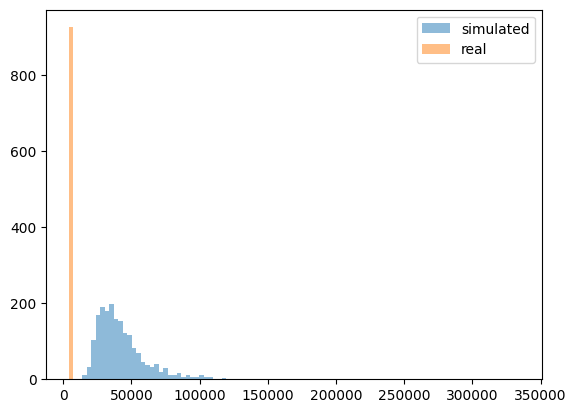

In [29]:
cased_duration_simulated = event_log.groupby('case:concept:name')['duration_sampled'].sum()
bins = 100
r = plt.hist(case_duration_log['case_duration_seconds'], bins, alpha=0.5, label='simulated')
plt.hist(cased_duration_simulated, r[1], alpha=0.5, label='real')
plt.legend(loc='upper right')
plt.show()